In [1]:
%matplotlib inline
#This is what %pylab does:
# import numpy
# import matplotlib
# from matplotlib import pylab, mlab, pyplot
# np = numpy
# plt = pyplot
# from IPython.core.pylabtools import figsize, getfigs
# from pylab import *
# from numpy import *
#import matplotlib.pyplot as plt

import os
import sys
import time
import glob
import numpy as np
import cupy as cp
import pandas as pd
from struct import *
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

import skimage
#print(skimage.__version__)
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

import dask
import dask.array as da
from dask.distributed import Client, progress, get_task_stream
from dask.diagnostics import ProgressBar

import mrcfile
import pickle
import webbrowser
from IPython.display import IFrame

sys.path.append('/SIFT_gs/')
try:
    from SIFT_gs.FIBSEM_SIFT_gs import *
except:
    from FIBSEM_SIFT_gs import *

Open CV version:  4.6.0


C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

# This is where the data processing begins.

# Step 0a: Set up the Processing Parameters.

In [2]:
#data_dir = 'F:/FIB-SEM_SIFT/Test_data/AMST/subset'
data_dir = 'F:/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw'

ftype = 1 # 0 for Shan's .dat files, 1 for tif files

use_DASK = True

threshold_min = 1e-3    # This are used to determine Min and Max data boundaries for I8 conversion
threshold_max = 1e-3                            
sliding_minmax = True   # If True, Global Min and Max for I8 conversion the entire data set is used. If False, Min and Max are allowed to vary slowly.
nbins = 256             # Number of histogram bins for determining Min and Max above

BFMatcher = False       # If True, the BF Matcher is used for keypont matching
                        # otherwise FLANN Matcher (faster, preferable) is used.

save_matches = True     # If True, matches will be saved into individual files

kp_max_num = 100000      # max number of key-points to be matched. Key-points in every frame are indexed (in descending order)
                        # by the strength of the response. Only kp_max_num is kept for further processing.
                        # Set this value to -1 if you want to keep ALL keypoints (may take forever to process!)

# Uncomment one from the below choices:
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if TransformType == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])       # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

SIFT_nfeatures = 0     # SIFT libary default is 0. The number of best features to retain.
                                # The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
    
SIFT_nOctaveLayers = 3          # SIFT libary default  is 3. The number of layers in each octave.
                                # 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.

SIFT_contrastThreshold = 0.040   # SIFT libary default  is 0.04. The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions.
                                # The larger the threshold, the less features are produced by the detector.
                                # The contrast threshold will be divided by nOctaveLayers when the filtering is applied.
                                # When nOctaveLayers is set to default and if you want to use the value used in
                                # D. Lowe paper (0.03), set this argument to 0.09.
                                
SIFT_edgeThreshold = 10         # SIFT libary default  is 10. The threshold used to filter out edge-like features.
                                # Note that the its meaning is different from the contrastThreshold,
                                # i.e. the larger the edgeThreshold, the less features are filtered out
                                # (more features are retained).

SIFT_sigma = 1.6                # SIFT library default is 1.6. 	The sigma of the Gaussian applied to the input image at the octave #0.
                                # If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
    
Lowe_Ratio_Threshold = 0.7
    
solver = 'RANSAC'       # String indicating which solver is to be used.'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.
                        # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic

drmax = 1.5              # dimensions - pixels.
                         #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.
                         #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                         # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                         # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                         # until the worst error falls below drmax or the max number of iterations is reached.

max_iter = 1000     # max number of iterations in the iterative procedure above

save_data_as_tiff = False    # Convert and Save the InLens.tif data

save_res_png = True        # Save PNG images of the intemediate processing statistics and final registration quality check.

save_asI8 = False            # If true, the data will be converted to I8 using global MIN and MAX values determined in the Step 1

preserve_scales = True       # If True, the transformation matrix will be adjusted using the settings defined by fit_params below
fit_params = ['SG', 501, 3]  # perform the above adjustment using  Savitzky-Golay (SG) filter with parameters
                             # window size 701, polynomial order 3
#fit_params = ['LF']         # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)

subtract_linear_fit = [True, True]  # If True, the linear slopes along X- and Y- directions (respectively) will be subtracted from the cumulative shifts.
                                    # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 

pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

flipY = True                 # If True, the dataset will be flipped along Y-direction

zbin_factor =  1             # binning factor in z-direction (milling direction). Data will be binned when saving the final result. Default is 1.

int_order = 1                #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic
#suffix = suffix + '_r2'
#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************

if ftype == 0:
    fls = sorted(glob.glob(os.path.join(data_dir,'*.dat')))
    if len(fls) == 0 :
        fls = sorted(glob.glob(os.path.join(data_dir,'*/*.dat')))
if ftype == 1:
    fls = sorted(glob.glob(os.path.join(data_dir,'*.tif')))
    if len(fls) == 0 :
        fls = sorted(glob.glob(os.path.join(data_dir,'*/*.tif')))
nfrs = len(fls)

if fit_params[1] > nfrs//2*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//2*2-1

fnm0 = (os.path.join(data_dir,fls[0]))
frame0 = FIBSEM_frame(fnm0, ftype=ftype)
Sample_ID = frame0.Sample_ID.strip('\x00')
EightBit = frame0.EightBit
Sample_ID = 'AMST dataset'

SIFT_kwargs = {
    'ftype' : ftype,
    'data_dir' : data_dir,
    'Sample_ID' : Sample_ID,
    'EightBit' : EightBit,
    'use_DASK' : use_DASK,
    'threshold_min' : threshold_min, 
    'threshold_max' : threshold_max,
    'sliding_minmax' : sliding_minmax,
    'nbins' : nbins,
    'TransformType' : TransformType,
    'SIFT_nfeatures' : SIFT_nfeatures,
    'SIFT_nOctaveLayers' : SIFT_nOctaveLayers,
    'SIFT_contrastThreshold' : SIFT_contrastThreshold,
    'SIFT_edgeThreshold' : SIFT_edgeThreshold,
    'SIFT_sigma' : SIFT_sigma,
    'Lowe_Ratio_Threshold' : Lowe_Ratio_Threshold,
    'l2_matrix' : l2_matrix,
    'targ_vector': targ_vector, 
    'solver' : solver,
    'drmax' : drmax,
    'max_iter' : max_iter,
    'BFMatcher' : BFMatcher,
    'save_matches' : save_matches,
    'kp_max_num' : kp_max_num,
    'save_res_png' : save_res_png,
    'save_data_as_tiff' : save_data_as_tiff,
    'save_asI8' : save_asI8,
    'preserve_scales' : preserve_scales,
    'fit_params' : fit_params,
    'subtract_linear_fit' : subtract_linear_fit,
    'pad_edges' : pad_edges,
    'zbin_factor' : zbin_factor,
    'flipY' : flipY,
    'int_order' : int_order,
    'suffix' : suffix}

test_dataset = FIBSEM_dataset(fls, fnm_reg = 'Registered_I8_RegAffine.mrc', **SIFT_kwargs)

Total Number of frames:  1727
Registered data will be saved into:  Registered_I8_RegAffine.mrc


# Step 0b: Check the settings: Perform SIFT alignemebts ontwo frames in the middle of the stack

AMST dataset
Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 9.99937525e-01  5.63957103e-04 -6.67968004e-01]
 [ 2.81684592e-05  1.00015959e+00 -3.86012015e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1140 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 648
Wall time: 37.5 s


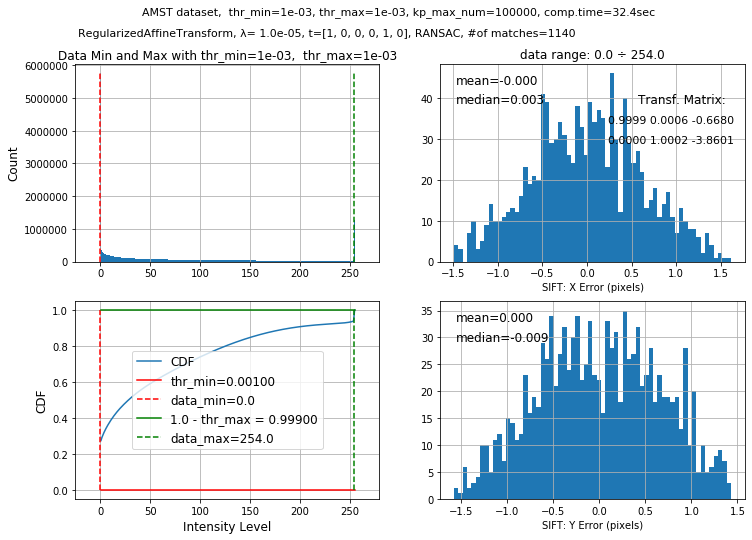

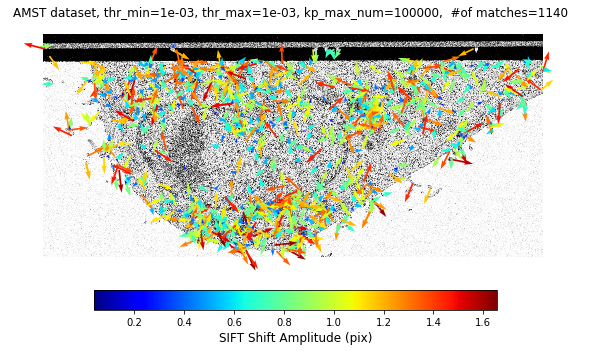

In [3]:
%%time
SIFT_evaluation_results = test_dataset.SIFT_evaluation()

# Now Perform SIFT Computations using DASK Distributed (local cluster, using SCATTER, MAP and GATHER)

# Step 1: Set up Local DASK Client and Monitor Window

In [4]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\distributed\bokeh\core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Using Local Port:    65396


# Step 2a: Save InLens.tif Data (Optional)

In [5]:
if save_data_as_tiff:
    test_dataset.convert_raw_data_to_tif_files(client)

# Step 2: Calculate the Global Data Range

Step 2: Calculate the Global Data Range
Original data is 8-bit, no need to find Min and Max for 8-bit conversion
Saving the Data Min/Max Statistics into the file:  F:/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw\Data_MinMax.xlsx
Loading SIFT kwarg Data
Loading MinMax Data
Generating Plot
Step 2: Elapsed time: 1.25 seconds
Global Data Range for I8 conversion:  Min=0.00, Max=255.00


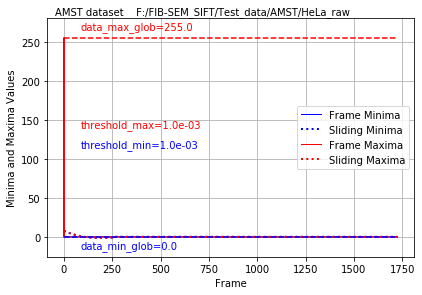

In [6]:
# Step 2: Calculate the Global Data Range

t0 = time.time()
print('Step 2: Calculate the Global Data Range')
data_minmax =  test_dataset.calc_data_range(client)
generate_report_data_minmax_xlsx(data_minmax[4], **SIFT_kwargs)

t1 = time.time()
print('Step 2: Elapsed time: {:.2f} seconds'.format(t1 - t0))
print('Global Data Range for I8 conversion:  Min={:.2f}, Max={:.2f}'.format(data_minmax[0], data_minmax[1]))

# Steps 3 and 4: Extract Key Points and Descriptors, Find Matches and Transformations

In [ ]:
# Step 3: Extract Key Points and Descriptors using DASK Distributed
t1 = time.time()
print('Step 3: Extract Key Points and Descriptors')
fnms = test_dataset.extract_keypoints(client)   
t2 = time.time()
print('Step 3: Elapsed time: {:.2f} seconds'.format(t2 - t1))
print('')

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(client)
t3 = time.time()
print('Step 4: Elapsed time: {:.2f} seconds'.format(t3 - t2))

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

Step 3: Extract Key Points and Descriptors
Using DASK distributed
Step 3: Elapsed time: 1968.83 seconds

Step 4: Select Good Matches with FLANN matcher
Step 4: using RegularizedAffineTransform Transformation Model with RANSAC solver
Step 4: RegularizedAffineTransform parameters:
Step 4: Regularization matrix: 
[[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Step 4: Target Solution:  [1 0 0 0 1 0]
Using DASK distributed


In [ ]:
# here is an example of how the previous step can be modified easily without having to re-do all previous steps
# this will calculate the cumulative transformation matrix WITHOT modifying the object property subtract_linear_fit
# so this change will NOT propagate.
# tr_matr_cum_residual = test_dataset.process_transformation_matrix(subtract_linear_fit = [False, True])
# if you want to make permanet change, then you should do this:
# test_dataset.subtract_linear_fit = [False, True]
# tr_matr_cum_residual = test_dataset.process_transformation_matrix()


# Step 5: Search for frames with no (or low # of) matches and possibly remove them.

In [ ]:
thr_npt = 3   # consider frame with less than 3 Key Points for removal
tr_matr_cum_residual = test_dataset.check_for_nomatch_frames(thr_npt, **SIFT_kwargs)

# Step 6: Recall or Save the Intermediate Data (KeyPoints, Matches, Transf.Matrix, etc.) from / into spreadsheets and a binary files.  Remove the intermediate KeyPoint/Descriptor files.

In [ ]:
recall_the_data = False          # if False, the data will be saved. if True, the data will be recalled

dump_file = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))

if recall_the_data:
    test_dataset = FIBSEM_dataset(fls, data_dir, recall_parameters=True, dump_filename=dump_filename, **SIFT_kwargs)
else:
    saved_dump_file = test_dataset.save_parameters(dump_file=dump_file)
    print('Parameters saved into the file: ', saved_dump_file)

In [ ]:
remove_key_points_data = False   # if True, the binary files with intermediate keypoints data for each frame will be removed

# Remove temporary files
if remove_key_points_data:
    # Remove the keypoint/ descriptor files
    for fnm in tqdm(fnms, desc='Removing KeyPoint/Descriptor Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass
    for fnm in tqdm(fnms_matches, desc='Removing Matched KeyPoint Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass


In [ ]:
# evaluation_box = [250, 2000, 1450, 2650]      # optional evaluation box for defining the area over which the registration quality
# test_dataset.show_eval_box(evaluation_box = evaluation_box, invert_data=False)
#
# default frames are three frames: 10% from the start, 50% from the start, and 90% from the start
# alternatively you can set any list of frame indecis by using keyword frame_indices
# for example:0
# test_dataset.show_eval_box(frame_indices=[1, 100, 850], evaluation_box = evaluation_box, invert_data=False)
#

evaluation_box = [600, 2000, 1450, 2650]
test_dataset.show_eval_box(evaluation_box = evaluation_box, invert_data=False, flipY=True)

# Step 7: Transform and Save the FIB-SEM data

In [ ]:
%%time

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [600, 2000, 1450, 2650]
reg_summary_regaffine, reg_summary_regaffine_xlsx = test_dataset.transform_and_save(client,
                                                                                    use_DASK=False,
                                                                                    flipY=True,
                                                                                    save_transformed_dataset = True,
                                                                                    save_registration_summary = True,
                                                                                    evaluation_box = evaluation_box) # following additional keys are available:
                                                #
                                                # perfrom_transformation (default=True). Set to false if you want to save the raw data into a single stack
                                                # and evaluare raw registration quality
                                                #
                                                # invert_data (default=False). Set to True if you want to invert te data
                                                #
                                                # evaluation_box (default [0, -1, 0, -1]. Set boundaries ([top, height, left, width]))
                                                # of the image subset to be used for registration quality evaluation

generate_report_from_xls_registration_summary(reg_summary_regaffine_xlsx)

In [ ]:
%%time
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
#TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
test_dataset.TransformType = AffineTransform
SIFT_kwargs['TransformType'] = test_dataset.TransformType
test_dataset.fnm_reg = 'Registered_I8_Affine.mrc'

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(client)

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))
saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
print('Parameters saved into the file: ', saved_dump_file)

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [600, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

reg_summary_affine, reg_summary_affine_xlsx = test_dataset.transform_and_save(client,
                                                                              use_DASK=False,
                                                                              flipY=True,
                                                                              save_transformed_dataset = True,
                                                                              save_registration_summary = True,
                                                                              evaluation_box = evaluation_box)
generate_report_from_xls_registration_summary(reg_summary_affine_xlsx)

In [ ]:
%%time
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
#TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
test_dataset.TransformType = ScaleShiftTransform
SIFT_kwargs['TransformType'] = test_dataset.TransformType
test_dataset.fnm_reg = 'Registered_I8_ScaleShift.mrc'

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(client)

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))
saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
print('Parameters saved into the file: ', saved_dump_file)

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [600, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

reg_summary_scaleshift, reg_summary_scaleshift_xlsx = test_dataset.transform_and_save(client,
                                                                                    use_DASK=False,
                                                                                      flipY=True,
                                                                                    save_transformed_dataset = True,
                                                                                    save_registration_summary = True,
                                                                                    evaluation_box = evaluation_box)
generate_report_from_xls_registration_summary(reg_summary_scaleshift_xlsx)

In [ ]:
%%time
#TransformType = ShiftTransform                #  only x-shift and y-shift
#TransformType = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#TransformType = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#TransformType = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
#TransformType = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
test_dataset.TransformType = ShiftTransform
SIFT_kwargs['TransformType'] = test_dataset.TransformType
test_dataset.fnm_reg = 'Registered_I8_Shift.mrc'

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
matcher_str = 'BF' if BFMatcher else 'FLANN'
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + test_dataset.TransformType.__name__ + ' Transformation Model with ' + solver + ' solver')
if TransformType == RegularizedAffineTransform:
    print('Step 4: ' + test_dataset.TransformType.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(test_dataset.l2_matrix)
    print('Step 4: Target Solution: ', test_dataset.targ_vector)

results_s4 = test_dataset.determine_transformations(client)

tr_matr_cum_residual, tr_matr_cum_xlsx_file = test_dataset.process_transformation_matrix()
generate_report_transf_matrix_from_xlsx(tr_matr_cum_xlsx_file)

dump_filename = os.path.join(data_dir, test_dataset.fnm_reg.replace('.mrc', '_params.bin'))
saved_dump_file = test_dataset.save_parameters(dump_file=dump_filename)
print('Parameters saved into the file: ', saved_dump_file)

print('Step 7: Transform and Save the FIB-SEM data')

evaluation_box = [600, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

reg_summary_shift, reg_summary_shift_xlsx = test_dataset.transform_and_save(client,
                                                                            use_DASK=False,
                                                                            flipY=True,
                                                                            save_transformed_dataset = True,
                                                                            save_registration_summary = True,
                                                                            evaluation_box = evaluation_box)
generate_report_from_xls_registration_summary(reg_summary_shift_xlsx)

In [ ]:
data_dir_raw = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw'
fls_raw = sorted(glob.glob(os.path.join(data_dir_raw,'*.tif')))
test_dataset = FIBSEM_dataset(fls_raw, **SIFT_kwargs)
test_dataset.data_dir = data_dir_raw
test_dataset.fnm_reg = 'raw_data_orig.mrc'
data_minmax_raw =  test_dataset.calc_data_range(client)

evaluation_box = [600, 2000, 1450, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

raw_reg_summary, raw_reg_summary_xlsx = test_dataset.transform_and_save(client,
                                                                          use_DASK=True,
                                                                          invert_data=False,
                                                                        flipY=True,
                                                                          perfrom_transformation=False,
                                                                          save_transformed_dataset = False,
                                                                          save_registration_summary = True,
                                                                          evaluation_box = evaluation_box)
generate_report_from_xls_registration_summary(raw_reg_summary_xlsx)

In [ ]:
orig_mrc_stack = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data.mrc'
evaluation_box = [700, 2000, 1450, 2650]
show_eval_box_mrc_stack(orig_mrc_stack, evaluation_box = evaluation_box)

In [ ]:
# alternative way - combine all tif files into a single mrc stack and then evaluate
evaluation_box = [700, 2000, 1450, 2650]
orig_mrc_stack = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data.mrc'
save_filename  = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_raw/Original/Original_Data_withEB1.mrc'
reg_summary_raw1, reg_summary_raw_xlsx1 = analyze_mrc_stack_registration(orig_mrc_stack, client,
                                                                        use_DASK=True,
                                                                        invert_data=False,
                                                                       evaluation_box = evaluation_box,
                                                                      save_filename=save_filename)
generate_report_from_xls_registration_summary(reg_summary_raw_xlsx1)

In [ ]:
data_dir_AMST = 'Z:/Python_Scripts/FIB-SEM_SIFT/Test_data/AMST/HeLa_amst_aligned'
fls_AMST = sorted(glob.glob(os.path.join(data_dir_AMST,'*.tif')))
test_dataset = FIBSEM_dataset(fls_AMST, **SIFT_kwargs)
test_dataset.data_dir = data_dir_AMST
test_dataset.fnm_reg = 'AMST_Data_orig.mrc'
data_minmax_AMST =  test_dataset.calc_data_range(client)

evaluation_box = [500, 2000, 1340, 2650]       # optional evaluation box for defining the area over which the registration quality
                                                # is evaluated. It can be checked in the step above. The use 
                                                # of the method below would be:

AMST_reg_summary, AMST_reg_summary_xlsx = test_dataset.transform_and_save(client,
                                                                          use_DASK=True,
                                                                          invert_data=True,
                                                                          flipY=True,
                                                                          perfrom_transformation=False,
                                                                          save_transformed_dataset = False,
                                                                          save_registration_summary = True,
                                                                          evaluation_box = evaluation_box)
generate_report_from_xls_registration_summary(AMST_reg_summary_xlsx)

In [ ]:
test_dataset.estimate_SNRs(evaluation_box = evaluation_box, invert_data=True)

generating the registration quality summary plots:   0%|          | 0/6 [00:00<?, ?it/s]

generating the summary table: 0it [00:00, ?it/s]

generating the registration quality summary plots:   0%|          | 0/6 [00:00<?, ?it/s]

generating the summary table: 0it [00:00, ?it/s]

Saving the summary figure into file:  F:/FIB-SEM_SIFT/Test_data/AMST\HeLa_Raw\Regstration_Summary_fig_and_table.png


saving the data into xlsx file:   0%|          | 0/6 [00:00<?, ?it/s]

'F:/FIB-SEM_SIFT/Test_data/AMST\\HeLa_Raw\\Regstration_Summary.xlsx'

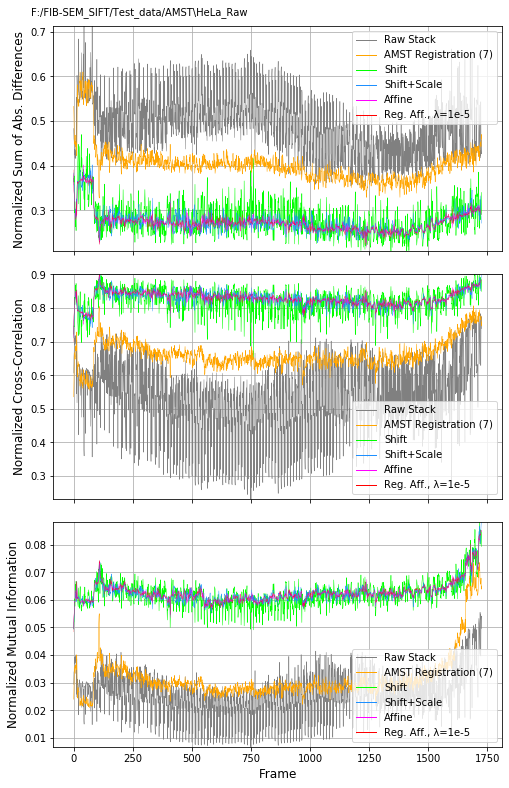

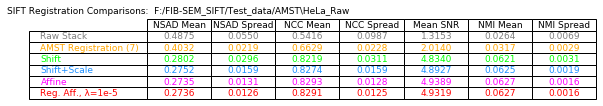

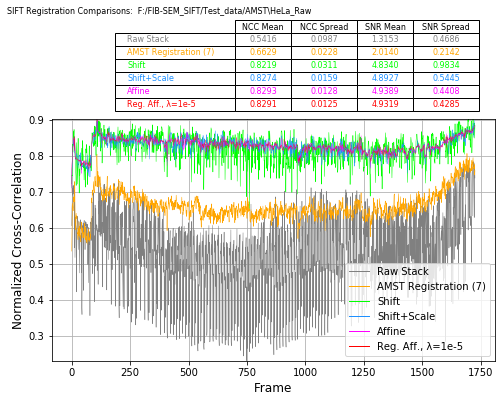

In [32]:
data_dir = 'F:/FIB-SEM_SIFT/Test_data/AMST'

reg_quality_files = ['HeLa_Raw/Original_Raw_Data_RegistrationQuality.csv',
                     'HeLa_amst_aligned/AMST_Data_inverted_RegistrationQuality.csv',
                     'HeLa_Raw/Registered_I16_Shift_RegistrationQuality.csv',
                     'HeLa_Raw/Registered_I16_ScaleShift_RegistrationQuality.csv',
                     'HeLa_Raw/Registered_I16_Affine_RegistrationQuality.csv',
                     'HeLa_Raw/Registered_I8_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05_RegistrationQuality.csv']

colors = ['grey', 'orange', 'lime', 'dodgerblue', 'magenta', 'red']
linewidths = [0.5, 0.5, 0.5, 0.4, 0.3, 0.2]

reg_files = [os.path.join(data_dir, rf) for rf in reg_quality_files]

pfs = ['Raw Stack',
       'AMST Registration (7)',
       'Shift',
       'Shift+Scale',
       'Affine',
       'Reg. Aff., λ=1e-5']

plot_registrtion_quality_csvs(reg_files, pfs, colors=colors, linewidths=linewidths)